In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import rebound
import reboundx
%matplotlib inline

ODE
--

$R_1 = \alpha a_1^2 \mu_2 n_1^2 (be_1\cos{\phi_1}+ce_2\cos{\phi_2}+de_1^2\cos{2\phi_1}+fe_2^2\cos{2\phi_2})$

$R_2 = a_2^2 \mu_1 n_2^2 (be_1\cos{\phi_1}+ce_2\cos{\phi_2}+de_1^2\cos{2\phi_1}+fe_2^2\cos{2\phi_2})$

$\frac{d n_1}{dt} = -3\alpha\mu_2 n_1^2(be_1\sin{\phi_1}+ce_2\sin{\phi_2}+2de_1^2\sin{2\phi_1}+2fe_2^2\sin{2\phi_2}) + \frac{n_1}{\tau_{n1}} + \frac{3n_1e_1^2}{\tau_{e_1}}$

$\frac{d n_2}{dt} = 6 \mu_1 {n_2}^2 (be_1\sin{\phi_1}+ce_2\sin{\phi_2}+2de_1^2\sin{2\phi_1}+2fe_2^2\sin{2\phi_2}) + \frac{n_2}{\tau_{n2}} + \frac{3n_2e_2^2}{\tau_{e_2}}$

$\frac{d e_1}{dt} = -\alpha \mu_2 n_1 \frac{\sqrt{1-e_1^2}}{e_1}(1-\sqrt{1-e_1^2})(be_1\sin{\phi_1}+ce_2\sin{\phi_2}+2de_1^2\sin{2\phi_1}+2fe_2^2\sin{2\phi_2})-\alpha \mu_2 n_1 \frac{\sqrt{1-e_1^2}}{e_1}(be_1\sin{\phi_1}+2de_1^2\sin{2\phi_1}) - \frac{e_1}{\tau_{e_1}}$

$\frac{d e_2}{dt} = \mu_1 n_2 \frac{\sqrt{1-e_2^2}}{e_2} (1-\sqrt{1-e_2^2})(2be_1\sin{\phi_1}+2ce_2\sin{\phi_2}+4de_1^2\sin{2\phi_1}+4fe_2^2\sin{2\phi_2}) - \mu_1 n_2 \frac{\sqrt{1-e_2^2}}{e_2} (ce_2\sin{\phi_2}+2fe_2^2\sin{2\phi_2})-\frac{e_2}{\tau_{e_2}}$

$\frac{d\varpi_1}{dt} = \alpha \mu_2 n_1 \frac{\sqrt{1-e_1^2}}{e_1}(b\cos{\phi_1}+2de_1\cos{2\phi_1})$

$\frac{d\varpi_2}{dt} = \mu_1 n_2 \frac{\sqrt{1-e_2^2}}{e_2}(c\cos{\phi_2}+2fe_2\cos{2\phi_2})$

$\frac{d\epsilon_1}{dt} = -2\alpha \mu_2n_1(b_1e_1\cos{\phi_1}+c_1e_2\cos{\phi_2}+d_1e_1^2\cos{\phi_1}+f_1e_2^2\cos{2\phi_2}) +\alpha\mu_2n_1\frac{\sqrt{1-e_1^2}}{e_1}(1-\sqrt{1-e_1^2})(b\cos{\phi_1}+2de_1\cos{2\phi_1})$

$\frac{d\epsilon_2}{dt} = 2\mu_1n_2(b_2 e_1\cos{\phi_1}+c_2 e_2\cos{\phi_2}+d_2 e_1^2\cos{\phi_1}+f_2 e_2^2\cos{2\phi_2}) + \mu_1n_2\frac{\sqrt{1-e_2^2}}{e_2}(1-\sqrt{1-e_2^2})(c\cos{\phi_2}+2fe_2\cos{2\phi_2})$

$\frac{d\sigma}{dt} = 2(n_2+\dot{\epsilon}_2) - (n_1+\dot{\epsilon}_1)$





In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11
yr = 365*24*3600 # s
G = 6.6743e-11 # SI units
c_light = 3e8


m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 1.0 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1.0 # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun # or R_Sun



In [3]:
mstar = 0.31 * m_Sun # in [kg]
mu1 = 9.7e-6
mu2 = 4.8e-5

tau_n1 = 5e4 * yr # in [s]
tau_n2 = 5e3 * yr # in [s]
tau_e1 = tau_n1/10.
tau_e2 = tau_n2/10.

alpha = 0.6299 # a1/a2
b = -1.190
c = 0.428
d = 1.696
f = 3.594
b1 = -3.295
c1 = 1.754
d1 = 8.391
f1 = 11.407
b2 = -4.485
c2 = 5.958
d2 = 10.087
f2 = 14.310


In [4]:
def ode(R, t):
    n1, n2, e1, e2, pomega1, pomega2, sigma = R
    
    phi1 = sigma - pomega1
    phi2 = sigma - pomega2
    
    dn1dt = -3*alpha*mu2*n1**2* ( b*e1*np.sin(phi1)+c*e2*np.sin(phi2)+2*d*e1**2*np.sin(2*phi1) + 2*f*e2**2*np.sin(2*phi2)) + n1/tau_n1 + 3*n1*(e1**2)/tau_e1
    dn2dt = 6*mu1*n2**2*(b*e1*np.sin(phi1)+c*e2*np.sin(phi2) + 2*d*e1**2*np.sin(2*phi1) + 2*f*e2**2*np.sin(2*phi2)) + n2/tau_n2 + 3*n2*(e2**2)/tau_e2
    
    de1dt = -alpha*mu2*n1*np.sqrt(1-e1**2)*(1-np.sqrt(1-e1**2))/e1 * (b*e1*np.sin(phi1)+c*e2*np.sin(phi2)+2*d*e1**2*np.sin(2*phi1)+2*f*e2**2*np.sin(2*phi2)) - alpha*mu2*n1*np.sqrt(1-e1**2)/e1 * (b*e1*np.sin(phi1)+2*d*e1**2*np.sin(2*phi1)) - e1/tau_e1
    de2dt = mu1*n2**np.sqrt(1-e2**2)*(1-np.sqrt(1-e2**2))/e2 * (2*b*e1*np.sin(phi1)+2*c*e2*np.sin(phi2)+4*d*e1**2*np.sin(2*phi1)+4*f*e2**2*np.sin(2*phi2)) - mu1*n2**np.sqrt(1-e2**2)/e2 * (c*e2*np.sin(phi2)+2*f*e2**2*np.sin(2*phi2))- e2/tau_e2
    
    dpomega1dt = alpha*mu2*n1*np.sqrt(1-e1**2)/e1 * (b*np.cos(phi1)+2*d*e1*np.cos(2*phi1))
    dpomega2dt = mu1*n2**np.sqrt(1-e2**2)/e2 * (c*np.cos(phi2)+2*f*e2*np.cos(2*phi2))
    
    depsilon1dt = -2*alpha*mu2*n1*(b1*e1*np.cos(phi1)+c1*e2*np.cos(phi2) + 2*d1*e1**2*np.cos(2*phi1) + 2*f1*e2**2*np.cos(2*phi2)) + alpha*mu2*n1*np.sqrt(1-e1**2)*(1-np.sqrt(1-e1**2))/e1 * (b*e1*np.cos(phi1)+2*d*e1**2*np.cos(2*phi1))
    depsilon2dt = 2*mu1*n2*(b2*e1*np.cos(phi1)+c2*e2*np.cos(phi2) + 2*d2*e1**2*np.cos(2*phi1) + 2*f2*e2**2*np.cos(2*phi2)) + mu1*n2*np.sqrt(1-e2**2)*(1-np.sqrt(1-e2**2))/e2 * (c*e2*np.cos(phi2)+2*f*e2**2*np.cos(2*phi2))
    
    dsigmadt = 2*n2-n1 + 2*depsilon2dt - depsilon1dt
    
    dRdt=[dn1dt, dn2dt, de1dt, de2dt, dpomega1dt, dpomega2dt, dsigmadt]
    
    return dRdt 


In [5]:
a1 = 0.11 * AU_To_Meter
a2 = 0.18 * AU_To_Meter
n1_initial = np.sqrt(G*mstar/(a1**3))
n2_initial = np.sqrt(G*mstar/(a2**3))
e1_initial = 1e-3
e2_initial = 1e-3
pomega1_initial = np.pi
pomega2_initial = 0
sigma_initial = np.pi

R0=[n1_initial, n2_initial, e1_initial, e2_initial, pomega1_initial, pomega2_initial, sigma_initial]
t=np.linspace(0, 30000*yr, 10000)
sol=odeint(ode, R0, t)


/Users/minliqiu/anaconda3/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [6]:
sol

array([[ 3.03965174e-06,  1.45212532e-06,  1.00000000e-03, ...,
         3.14159265e+00,  0.00000000e+00,  3.14159265e+00],
       [ 3.03983420e-06,  1.45299696e-06,  1.00686899e-03, ...,
        -9.56249183e+00, -7.56658120e-03, -9.59547908e+00],
       [ 3.04001671e-06,  1.45386912e-06,  1.01569066e-03, ...,
        -2.21476316e+01, -8.72117527e-03, -2.21848183e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

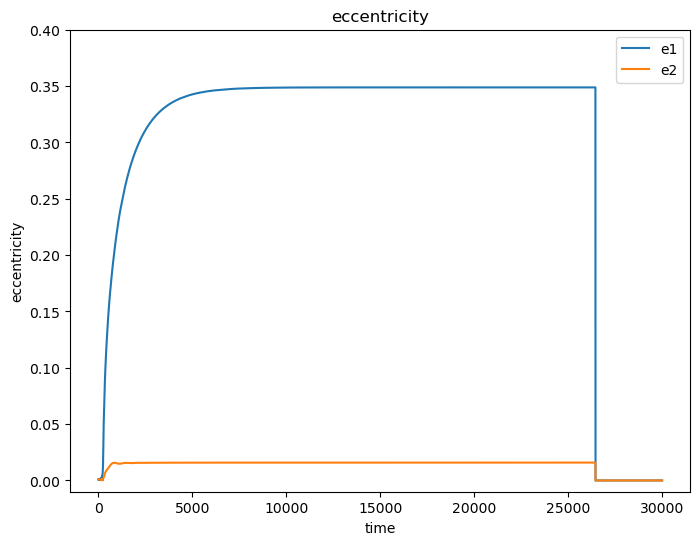

In [90]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
ax.set_ylim([-0.01, 0.4])
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel("eccentricity")
plt.plot(t/yr, sol[:, 2], label='e1')
plt.plot(t/yr, sol[:, 3], label='e2')
plt.legend()
plt.show()

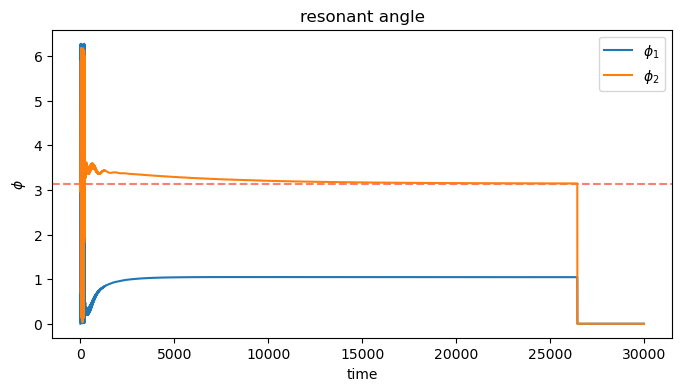

In [73]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
plt.title("resonant angle")
plt.xlabel("time")
plt.ylabel(r"$\phi$")
plt.axhline(y=np.pi, linestyle='--', color='salmon')
plt.plot(t/yr, (sol[:, 6]-sol[:, 4])%(2*np.pi), label=r'$\phi_1$')
plt.plot(t/yr, (sol[:, 6]-sol[:, 5])%(2*np.pi), label=r'$\phi_2$')
plt.legend()
plt.show()

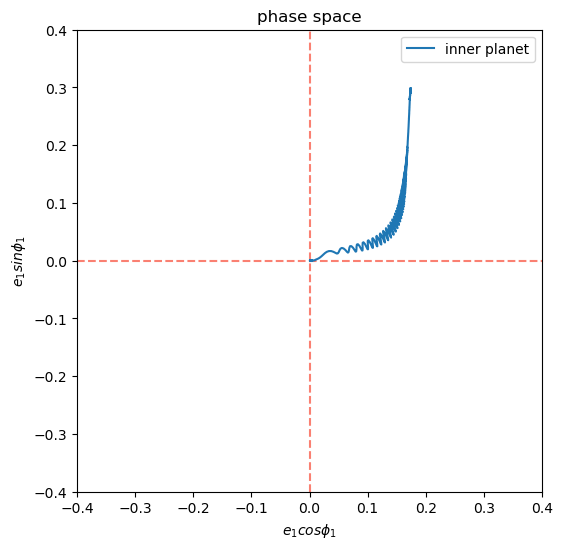

In [81]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.4, 0.4])
ax.set_ylim([-0.4, 0.4])
plt.title("phase space")
plt.xlabel(r"$e_1cos\phi_1$")
plt.ylabel(r"$e_1sin\phi_1$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:2000, 2])*np.cos(sol[0:2000, 6]-sol[0:2000, 4]), (sol[0:2000, 2])*np.sin(sol[0:2000, 6]-sol[0:2000, 4]), label='inner planet')
plt.legend()
plt.show()

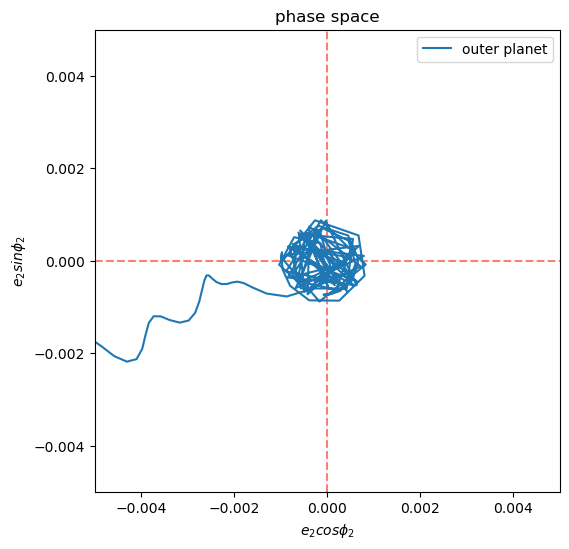

In [84]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.005, 0.005])
ax.set_ylim([-0.005, 0.005])
plt.title("phase space")
plt.xlabel(r"$e_2cos\phi_2$")
plt.ylabel(r"$e_2sin\phi_2$")
plt.axhline(y=0, linestyle='--', color = 'salmon')
plt.axvline(x=0, linestyle='--', color = 'salmon')
plt.plot((sol[0:2000, 3])*np.cos(sol[0:2000, 6]-sol[0:2000, 5]), (sol[0:2000, 3])*np.sin(sol[0:2000, 6]-sol[0:2000, 5]), label='outer planet')
plt.legend()
plt.show()

REBOUND
--

In [11]:
sim = rebound.Simulation()
sim.integrator = "ias15"
# sim.ri_ias15.epsilon=0
sim.units = ('m', 's', 'kg')
sim.G = 6.674e-11 # SI units
sim.dt = 1e1 # Initial timestep in sec.

mu1 = 9.7e-6
mu2 = 4.8e-5
a1 = 0.11 * AU_To_Meter
a2 = 0.18 * AU_To_Meter

sim.add(m=mstar, hash="Star") # add Sun with mass in kg
sim.add(m=mu1*mstar, a=a1, pomega=np.pi, l=0, hash="Planet_1")
sim.move_to_com()
sim.add(m=mu2*mstar, a=a2, pomega=0, l=np.pi/2, hash="Planet_2")


ps = sim.particles

sim.status()

---------------------------------
REBOUND version:     	3.24.0
REBOUND built on:    	Mar 28 2023 02:54:30
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	10.000000
---------------------------------
<rebound.particle.Particle object at 0x7febe36c84c0, m=6.169e+29 x=-159621.65166997878 y=3.909602895845066e-11 z=0.0 vx=-1.1883621813097815e-16 vy=-0.4851856805313849 vz=0.0>
<rebound.particle.Particle object at 0x7febe36c8d40, m=5.98393e+24 x=16455840378.34833 y=-4.03051844932481e-06 z=0.0 vx=1.2251156508348264e-11 vy=50019.14232282319 vz=0.0>
<rebound.particle.Particle object at 0x7febe36c84c0, m=2.96112e+25 x=1.6488644503719963e-06 y=26928000000.0 z=0.0 vx=-39103.07995876342 vy=2.394373085415132e-12 vz=0.0>
---------------------------------


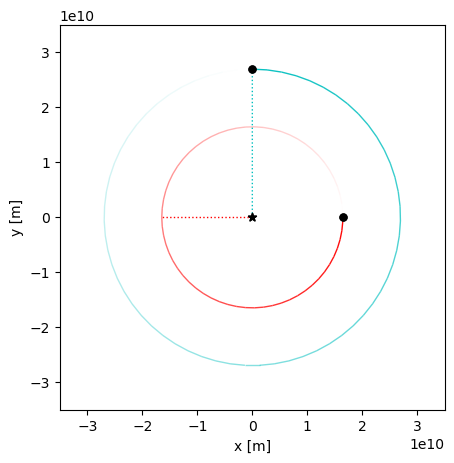

In [12]:
op = rebound.OrbitPlot(sim, unitlabel="[m]", color=True, periastron=True)

In [13]:
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces") # orbit-averaged
rebx.add_force(mof)

In [14]:
tau_n1 = 5e4 * yr # in [s]
tau_n2 = 5e3 * yr # in [s]
tau_e1 = tau_n1/10.
tau_e2 = tau_n2/10.

ps["Planet_1"].params["tau_a"] = -1.5 * tau_n1
ps["Planet_1"].params["tau_e"] = -tau_e1
ps["Planet_2"].params["tau_a"] = -1.5 * tau_n2
ps["Planet_2"].params["tau_e"] = -tau_e2


In [15]:
def get_H_sim(sim):
    
    a1, a2 = ps['Planet_1'].a, ps['Planet_2'].a
    e1, e2 = ps['Planet_1'].e, ps['Planet_2'].e
    n1, n2 = ps['Planet_1'].n, ps['Planet_2'].n
    phi1 = 2*ps['Planet_2'].l -  ps['Planet_1'].l - ps['Planet_1'].pomega
    phi2 = 2*ps['Planet_2'].l -  ps['Planet_1'].l - ps['Planet_2'].pomega
    
    mstar = 0.31 * m_Sun # in [kg]
    mu1 = 9.7e-6 # m1/m_Sun
    mu2 = 4.8e-5 # m2/m_Sun
    
    H10 = -0.5*G*(mstar+mu1*mstar)/a1
    R1 = alpha*a1**2*mu2*n1**2*(b*e1*np.cos(phi1)+c*e2*np.cos(phi2)+d*e1**2*np.cos(2*phi1)+f*e2**2*np.cos(2*phi2))
    H1_sim = H10 - R1
    
    H20 = -0.5*G*(mstar+mu2*mstar)/a2
    R2 = a2**2*mu1*n2**2*(b*e1*np.cos(phi1)+c*e2*np.cos(phi2)+d*e1**2*np.cos(2*phi1)+f*e2**2*np.cos(2*phi2))
    H2_sim = H20 - R2

    return H1_sim, H2_sim


In [16]:
%%time

yr = 365*24*3600 # s

Noutput = 1000
times = np.linspace(0*yr, 5000*yr, Noutput)

e_1, a_1, n_1, kappa_1, resonant_angle_1 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e_2, a_2, n_2, kappa_2, resonant_angle_2 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
H1, H2 = np.zeros(Noutput), np.zeros(Noutput)


for i, time in enumerate(times):
    sim.integrate(time)
    
    e_1[i], a_1[i], n_1[i] = ps["Planet_1"].e, ps["Planet_1"].a, ps["Planet_1"].n
    resonant_angle_1[i] = 2*ps["Planet_2"].l -  ps['Planet_1'].l - ps['Planet_1'].pomega
    e_2[i], a_2[i], n_2[i] = ps["Planet_2"].e, ps["Planet_2"].calculate_orbit().a, ps["Planet_2"].calculate_orbit().n
    resonant_angle_2[i] = 2*ps["Planet_2"].l -  ps['Planet_1'].l - ps['Planet_2'].pomega
    
    H1[i], H2[i] = get_H_sim(sim)
    

CPU times: user 1min 22s, sys: 305 ms, total: 1min 23s
Wall time: 1min 22s


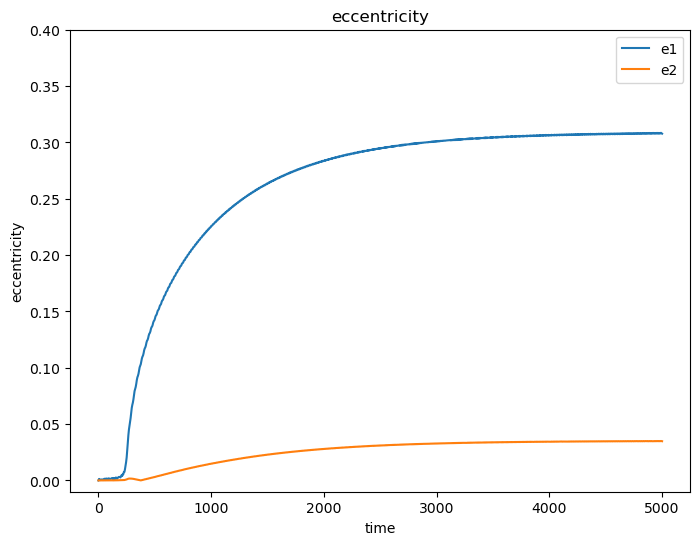

In [85]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
# ax.set_xlim([0,1.5])
ax.set_ylim([-0.01, 0.4])
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel("eccentricity")
plt.plot(times/yr, e_1, label='e1')
plt.plot(times/yr, e_2, label='e2')
plt.legend()
plt.show()

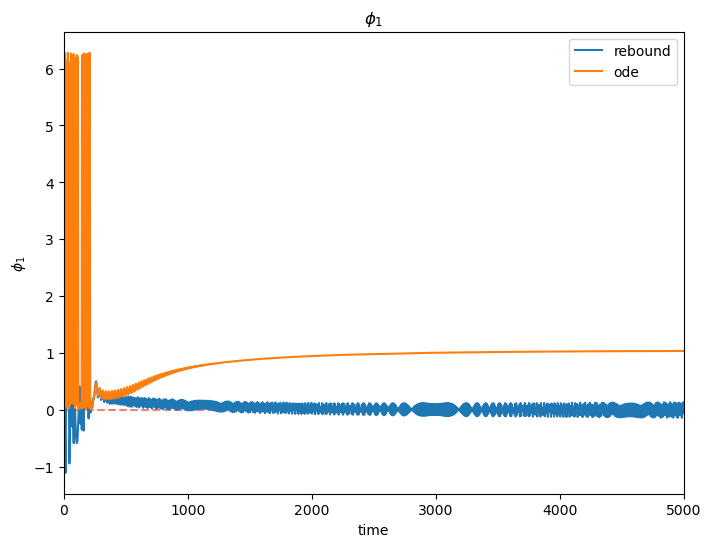

In [95]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlim([0,5000])
# ax.set_ylim([-1.5,2.5])
plt.title(r'$\phi_1$')
plt.xlabel("time")
plt.ylabel(r'$\phi_1$')
plt.axhline(y=0, linestyle='--', color='salmon')
plt.plot(times/yr, (np.pi+resonant_angle_1)%(2*np.pi)-np.pi, label='rebound')
plt.plot(t/yr, (sol[:, 6]-sol[:, 4])%(2*np.pi), label='ode')
plt.legend()
plt.show()


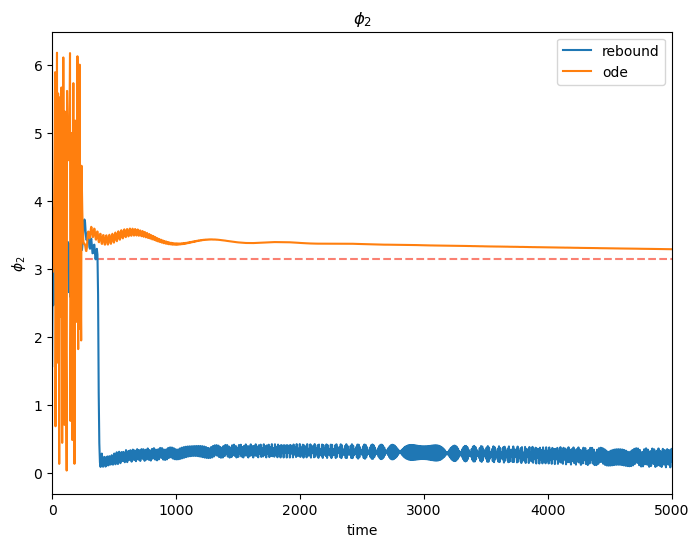

In [96]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlim([0,5000])
# ax.set_ylim([-1.5,2.5])
plt.title(r'$\phi_2$')
plt.xlabel("time")
plt.ylabel(r'$\phi_2$')
plt.axhline(y=np.pi, linestyle='--', color='salmon')
plt.plot(times/yr, resonant_angle_2%(2*np.pi), label='rebound')
plt.plot(t/yr, (sol[:, 6]-sol[:, 5])%(2*np.pi), label='ode')
plt.legend()
plt.show()


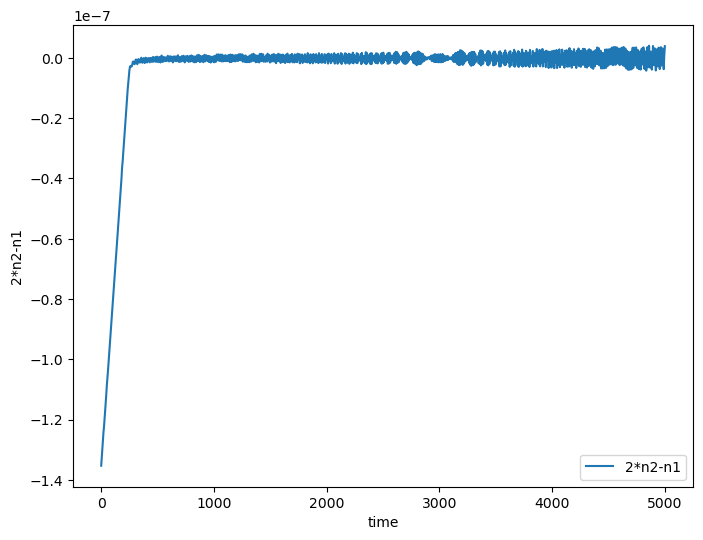

In [21]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.xlabel("time")
plt.ylabel("2*n2-n1")
plt.plot(times/yr, 2*n_2-n_1, label='2*n2-n1')
plt.legend()
plt.show()

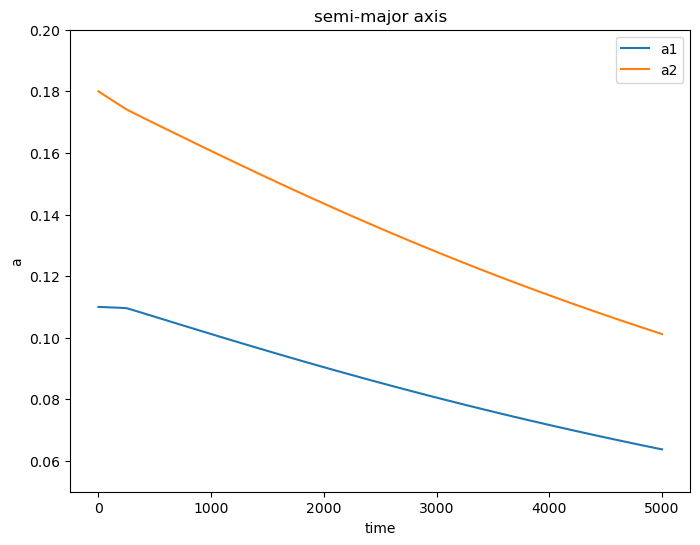

In [86]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
ax.set_ylim([0.05, 0.2])
plt.title("semi-major axis")
plt.xlabel("time")
plt.ylabel("a")
plt.plot(times/yr, a_1/AU_To_Meter, label='a1')
plt.plot(times/yr, a_2/AU_To_Meter, label='a2')
plt.legend()
plt.show()

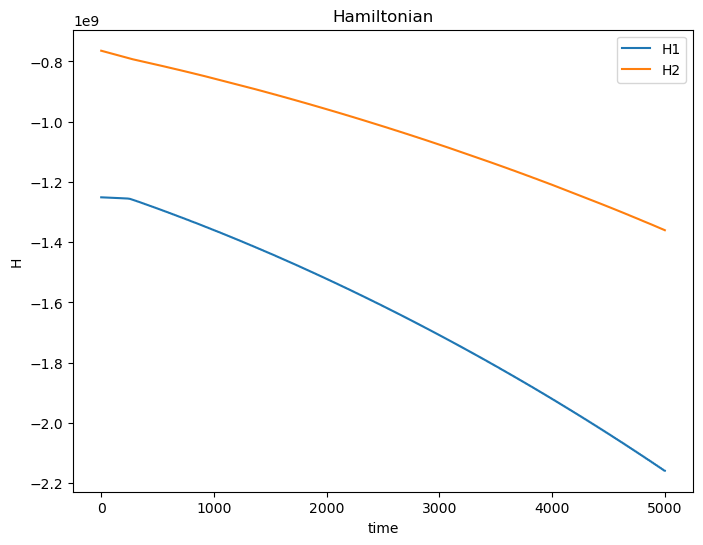

In [23]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.title("Hamiltonian")
plt.xlabel("time")
plt.ylabel("H")
plt.plot(times/yr, H1, label='H1')
plt.plot(times/yr, H2, label='H2')
plt.legend()
plt.show()

phase space
--

In [30]:
ecosphi1 = e_1*np.cos(resonant_angle_1)
esinphi1 = e_1*np.sin(resonant_angle_1)

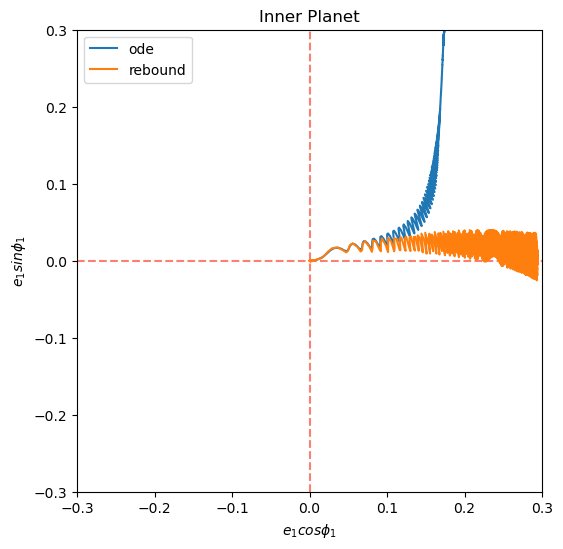

In [68]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
plt.title('Inner Planet')
plt.xlabel(r"$e_1cos\phi_1$")
plt.ylabel(r"$e_1sin\phi_1$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:2000, 2])*np.cos(sol[0:2000, 6]-sol[0:2000, 4]), (sol[0:2000, 2])*np.sin(sol[0:2000, 6]-sol[0:2000, 4]), label='ode')
plt.plot(ecosphi1[0:500], esinphi1[0:500], label='rebound')
plt.legend()
plt.show()

In [33]:
ecosphi2 = e_2*np.cos(resonant_angle_2)
esinphi2 = e_2*np.sin(resonant_angle_2)

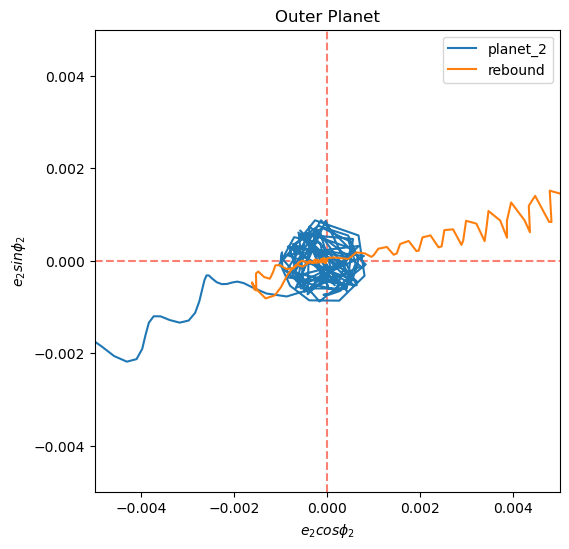

In [67]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.005, 0.005])
ax.set_ylim([-0.005, 0.005])
plt.title('Outer Planet')
plt.xlabel(r"$e_2cos\phi_2$")
plt.ylabel(r"$e_2sin\phi_2$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:2000, 3])*np.cos(sol[0:2000, 6]-sol[0:2000, 5]), (sol[0:2000, 3])*np.sin(sol[0:2000, 6]-sol[0:2000, 5]), label='planet_2')
plt.plot(ecosphi2[0:500], esinphi2[0:500], label='rebound')
plt.legend()
plt.show()